# Bible NLP

In this notebook, we will apply some natural language processing techniques to some chocen texts from the Gospels.

The goal is to verify the behavior of these techniques with these particular texts, in particular if they can capture information without changing the meaning of the text.

The verses are taken from the American Standard Version (ASV) of the Bible, available as csv file from this Kaggle [dataset](https://www.kaggle.com/datasets/oswinrh/bible/code).

In [17]:
import pandas as pd

def load_data():
    key2name = pd.read_csv('data/key_english.csv')
    key2name.drop(columns=['t', 'g'], inplace=True)

    bible_df = pd.read_csv('data/t_asv.csv')
    bible_df = bible_df[(bible_df['b'] >= 40) & (
        bible_df['b'] <= 43)]  # Matthew, Mark, Luke, John
    bible_df = bible_df.merge(key2name, on='b')

    # Given a reference return the text
    def get_verse_text(verse: str):
        reference = verse.split('-')
        book, start = reference[0].split(' ')
        start_chapter, start_verse = start.split(',')
        if len(reference) == 2:
            end_chapter, end_verse = reference[1].split(',')
        else:
            end_chapter, end_verse = start_chapter, start_verse

        start = int(
            f"{key2name[key2name['n'] == book]['b'].values[0]:02d}{int(start_chapter):03d}{int(start_verse):03d}")
        end = int(
            f"{key2name[key2name['n'] == book]['b'].values[0]:02d}{int(end_chapter):03d}{int(end_verse):03d}")
        text = bible_df[(bible_df['id'] >= start) & (
            bible_df['id'] <= end)]['t'].str.cat(sep=' ')
        return text

    # List of verses to analyze and their category:
    # 0 - events
    # 1 - parables
    # 2 - miracles
    # 3 - teachings
    verses = {
        'Matthew 1,18-1,25': 0,     # Nascità di Gesù secondo Matteo
        'Matthew 3,13-3,17': 0,     # Battesimo di Gesù secondo Matteo
        'Matthew 4,1-4,11': 0,      # Tentazioni di Gesù secondo Matteo
        'Matthew 5,1-7,29': 3,      # Discorso della montagna
        'Matthew 9,18-9,26': 2,     # Risurrezione della figlia di Giairo e guarigione della donna malata
        'Matthew 13,1-13,9': 1,     # Parabola del seminatore
        'Matthew 13,44-13,46': 1,   # Parabola del tesoro e della perla
        'Matthew 17,1-17,8': 0,     # Trasfigurazione di Gesù
        'Matthew 18,1-18,5': 3,     # I più piccoli nel regno dei cieli
        'Matthew 28,1-28,8': 0,     # Risurrezione di Gesù secondo Matteo
        'Mark 1,9-1,11': 0,         # Battesimo di Gesù secondo Marco
        'Mark 4,1-4,9': 1,          # Parabola del seminatore
        'Mark 4,35-4,41': 2,        # Tempesta sedata
        'Mark 8,34-8,38': 3,        # Rinnegarsi per seguire Gesù
        'Mark 9,2-9,8': 0,          # Trasfigurazione di Gesù
        'Mark 10,13-10,16': 3,      # I più piccoli nel regno dei cieli
        'Mark 16,1-16,8': 0,        # Risurrezione di Gesù secondo Marco
        'Luke 1,26-1,38': 0,        # Annunciazione a Maria
        'Luke 2,1-2,20': 0,         # Nascita di Gesù secondo Luca
        'Luke 3,21-3,22': 0,        # Battesimo di Gesù secondo Luca
        'Luke 4,1-4,13': 0,         # Tentazioni di Gesù secondo Luca
        'Luke 6,20-6,49': 3,        # Discorso della montagna secondo Luca
        'Luke 7,1-7,10': 2,         # Guarigione del servo del centurione
        'Luke 8,4-8,8': 1,          # Parabola del seminatore
        'Luke 9,28-9,36': 0,        # Trasfigurazione di Gesù
        'Luke 9,46-9,48': 3,        # I più piccoli nel regno dei cieli
        'Luke 15,11-15,32': 2,      # Parabola del figliol prodigo
        'Luke 24,1-24,12': 0,       # Risurrezione di Gesù secondo Luca
        'John 1,1-1,18': 3,         # Prologo del Vangelo secondo Giovanni
        'John 1,29-1,34': 0,        # Battesimo di Gesù secondo Giovanni
        'John 2,1-2,11': 2,         # Nozze di Cana
        'John 3,1-3,21': 3,         # Incontro con Nicodemo
        'John 4,1-4,42': 3,         # Incontro con la Samaritana
        'John 11,1-11,44': 2,       # Risurrezione di Lazzaro
        'John 13,1-17,26': 3,       # Ultima cena
        'John 20,1-20,18': 0        # Risurrezione di Gesù secondo Giovanni
    }

    # Get the text of the verses
    verses_text = [get_verse_text(verse) for verse in verses]

    # Save the verses text in a dataframe
    verses_df = pd.DataFrame({'verse': verses.keys(), 'text': verses_text, 'category': verses.values()})
    return verses_df

# Load the data
verses_df = load_data()
verses_df

,verse,text,category
0,"Matthew 1,18-1,25",Now the birth of Jesus Christ was on this wise...,0
1,"Matthew 3,13-3,17",Then cometh Jesus from Galilee to the Jordan u...,0
2,"Matthew 4,1-4,11",Then was Jesus led up of the Spirit into the w...,0
3,"Matthew 5,1-7,29","And seeing the multitudes, he went up into the...",3
4,"Matthew 9,18-9,26","While he spake these things unto them, behold,...",2
5,"Matthew 13,1-13,9","On that day went Jesus out of the house, and s...",1
6,"Matthew 13,44-13,46",The kingdom of heaven is like unto a treasure ...,1
7,"Matthew 17,1-17,8",And after six days Jesus taketh with him Peter...,0
8,"Matthew 18,1-18,5","In that hour came the disciples unto Jesus, sa...",3
9,"Matthew 28,1-28,8","Now late on the sabbath day, as it began to da...",0


## Classification

We will start by classifying the texts into four categories:

0. Events from the life of Jesus
1. Parables
2. Miracles
3. Teachings or discourses of Jesus

We have already classified the texts manually, the goal is to see and compare classification made by some different models (Decision Tree, Random Forest and Naive Bayes) and the real classification.

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
from sklearn.model_selection import cross_val_score

def classification(clf, verses_df, threshold):
    def preprocess(text, n):
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        ngrams_set = set()
        for i in range(1, n+1):
            processed_text = ngrams(tokens, i)
            ngrams_set.update([' '.join(gram) for gram in processed_text])
        return ngrams_set

    def build_token_dictionary(df: pd.DataFrame, column: str):
        tokens_dict = defaultdict(set)
        for idx, record in enumerate(df[column]):
            for token in record:
                tokens_dict[token].add(idx)
        return tokens_dict
    
    def entropy(df: pd.DataFrame):
        labels = set(df['category'].values)
        entropy = 0
        for label in labels:
            p = len(df[df['category'] == label]) / len(df)
            entropy -= p * np.log(p)
        return entropy
    
    def information_gain(df: pd.DataFrame, H, token: str):
        token_df = df[df['tokens'].apply(lambda x: token in x)]
        token_count = len(token_df)
        token_entropy = entropy(token_df)
        return H - token_count / len(df) * token_entropy
    
    def to_numeric(df: pd.DataFrame, best_features: pd.DataFrame, threshold):
        index = {}
        for idx, token in enumerate(best_features['token']):
            index[token] = idx
        numeric_df = np.zeros((len(df), threshold))
        target = np.zeros(len(df))

        for idx, record in df.iterrows():
            for token in record['tokens']:
                numeric_df[idx, index[token]] = 1
            target[idx] = record['category']
        return numeric_df, target
    
    verses_df = load_data()
    verses_df['tokens'] = verses_df['text'].apply(preprocess, n=3)
    tokens_dict = build_token_dictionary(verses_df, 'tokens')
    df_tokens = pd.DataFrame(zip(tokens_dict.keys(), tokens_dict.values()), columns=['token', 'verses'])

    count = []
    for t in df_tokens['verses']:
        count.append(len(t))
    df_tokens['count'] = count
    df_tokens = df_tokens[df_tokens['count'] > 1]

    H = entropy(verses_df)
    df_tokens['information_gain'] = df_tokens['token'].apply(lambda x: information_gain(verses_df, H, x))
    df_tokens.sort_values(by='information_gain', ascending=False, inplace=True)
    df_tokens = df_tokens[:threshold]

    new_texts = []
    for tokens in verses_df['tokens']:
        intesect = set(tokens).intersection(set(df_tokens['token'].values))
        new_texts.append(intesect)
    verses_df['tokens'] = new_texts
    numeric_df, target = to_numeric(verses_df, df_tokens, threshold)
    
    # The classifier is trained with a 4-fold cross validation
    scores = cross_val_score(clf, numeric_df, target, cv=4)
    return scores.mean(), scores.std()

We will compare mean and standard deviations of the cross-validation scores of the three models varying the number of features used.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

mean = []
std = []
decision_tree = DecisionTreeClassifier(random_state=1234567)
random_forest = RandomForestClassifier(random_state=1234567)
naive_bayes = MultinomialNB()

x_axis = range(100, 450, 50)

for i in x_axis:
    mean_dt, std_dt = classification(decision_tree, verses_df, i)
    mean_rf, std_rf = classification(random_forest, verses_df, i)
    mean_nb, std_nb = classification(naive_bayes, verses_df, i)
    mean.append((mean_dt, mean_rf, mean_nb))
    std.append((std_dt, std_rf, std_nb))

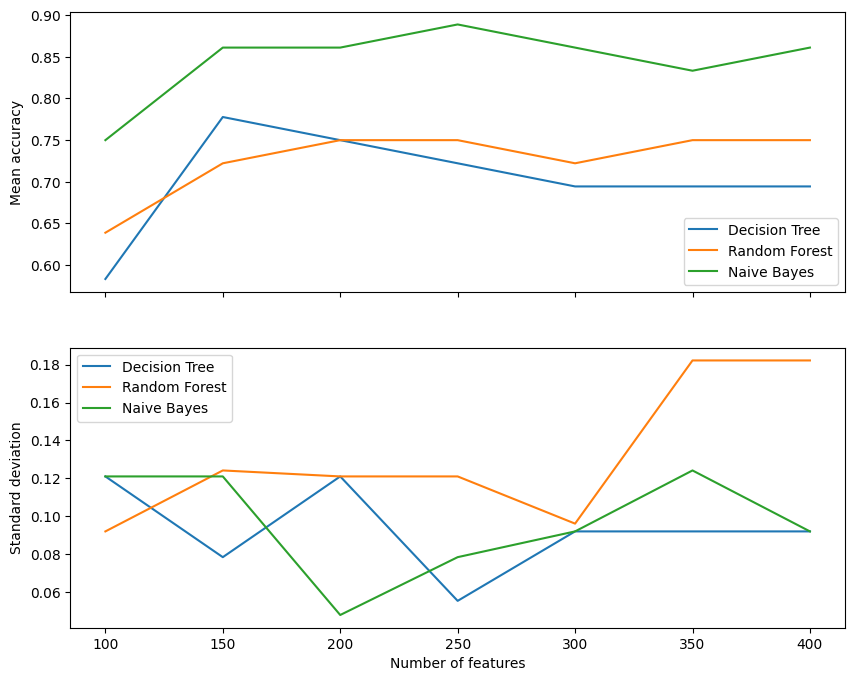

In [20]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
labels = ['Decision Tree', 'Random Forest', 'Naive Bayes']

ax1.plot(x_axis, mean, label=labels)
ax1.set(ylabel='Mean accuracy')
ax1.legend()

ax2.plot(x_axis, std, label=labels)
ax2.set(xlabel='Number of features', ylabel='Standard deviation')
ax2.legend()
plt.show()

From the graphs below, we can see that the best model is the Naive Bayes in all cases, while Decision Tree and Random Forest have similar performances.

The Naive Bayes model is also very stable, while the other two models tends to have a higher standard deviations.

The main problem of this comparison is that the result of this models are not deterministic, so the results can vary from run to run.

## Clustering

In this section we will try to cluster the texts. The goal is to see if the clusters are similar to the categories defined above and if parallel texts are clustered together.

In [41]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def preprocess(text, n):

    # To lower case and tokenization
    tokens = word_tokenize(text.lower())

    # Stop word and punctuation removal
    filtered_tokens = [token for token in tokens if token.isalpha() and (token not in stopwords.words('english'))]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    if n <= 1:
        return lemmatized_tokens
    
    # NGram generation
    ngram_set = []
    
    for i in range(1, n + 1):
        processed_text = ngrams(lemmatized_tokens, i)
        ngram_set.extend([' '.join(grams) for grams in processed_text])

    return ngram_set

def build_dictionary(df: pd.DataFrame, column: str):
    dictionary = defaultdict(dict)
    for idx, record in enumerate(df[column]):
        counter = Counter(record)
        for token in counter:
            dictionary[token][idx] = counter[token]
    return dictionary

verses_df = load_data()
verses_df['tokens'] = verses_df['text'].apply(preprocess, n=1)
dictionary = build_dictionary(verses_df, 'tokens')
verses_df['tokens'] = verses_df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)
X = vectorizer.fit_transform(verses_df['tokens'])
kmeans = KMeans(n_clusters=4, random_state=1234567, n_init='auto').fit(X)
clusters = kmeans.labels_

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=1234567)
pca_vecs = pca.fit_transform(X.toarray())
x = pca_vecs[:, 0]
y = pca_vecs[:, 1]
verses_df['cluster'] = clusters
verses_df['x'] = x
verses_df['y'] = y

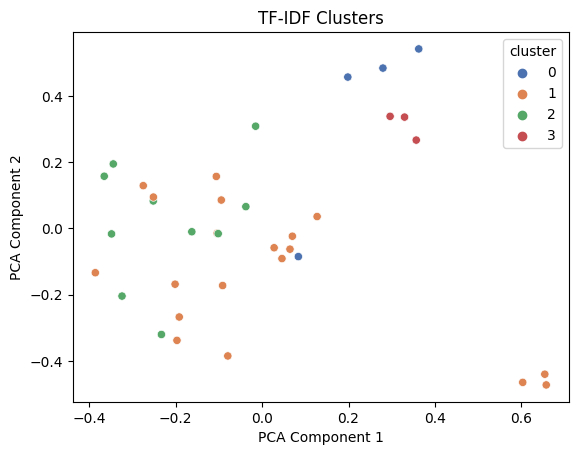

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.title("TF-IDF Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
sns.scatterplot(data=verses_df, x="x", y="y", hue="cluster", palette="deep")
plt.show()

Let's check if parallels texts are clustered together.

In [44]:
parallels = {
    'Matthew 1,18-1,25': {'Luke 2,1-2,20'},
    'Matthew 3,13-3,17': {'Mark 1,9-1,11', 'Luke 3,21-3,22'},
    'Matthew 4,1-4,11': {'Luke 4,1-4,13'},
    'Matthew 5,1-7,29': {'Luke 6,20-6,49'},
    'Matthew 9,18-9,26': {},
    'Matthew 13,1-13,9': {'Mark 4,1-4,9', 'Luke 8,4-8,8'},
    'Matthew 13,44-13,46': {},
    'Matthew 17,1-17,8': {'Mark 9,2-9,8', 'Luke 9,28-9,36'},
    'Matthew 18,1-18,5': {'Luke 9,46-9,48'},
    'Matthew 28,1-28,8': {'Mark 16,1-16,8', 'Luke 24,1-24,12', 'John 20,1-20,18'},
    'Mark 1,9-1,11': {'Matthew 3,13-3,17', 'Luke 3,21-3,22'},
    'Mark 4,1-4,9': {'Matthew 13,1-13,9', 'Luke 8,4-8,8'},
    'Mark 4,35-4,41': {},
    'Mark 8,34-8,38': {},
    'Mark 9,2-9,8': {'Matthew 17,1-17,8', 'Luke 9,28-9,36'},
    'Mark 10,13-10,16': {'Matthew 18,1-18,5', 'Luke 9,46-9,48'},
    'Mark 16,1-16,8': {'Matthew 28,1-28,8', 'Luke 24,1-24,12', 'John 20,1-20,18'},
    'Luke 1,26-1,38': {},
    'Luke 2,1-2,20': {'Matthew 1,18-1,25'},
    'Luke 3,21-3,22': {'Matthew 3,13-3,17', 'Mark 1,9-1,11'},
    'Luke 4,1-4,13': {'Matthew 4,1-4,11'},
    'Luke 6,20-6,49': {'Matthew 5,1-7,29'},
    'Luke 7,1-7,10': {},
    'Luke 8,4-8,8': {'Matthew 13,1-13,9', 'Mark 4,1-4,9'},
    'Luke 9,28-9,36': {'Matthew 17,1-17,8', 'Mark 9,2-9,8'},
    'Luke 9,46-9,48': {'Matthew 18,1-18,5', 'Mark 10,13-10,16'},
    'Luke 15,11-15,32': {},
    'Luke 24,1-24,12': {'Matthew 28,1-28,8', 'Mark 16,1-16,8', 'John 20,1-20,18'},
    'John 1,1-1,18': {},
    'John 1,29-1,34': {},
    'John 2,1-2,11': {},
    'John 3,1-3,21': {},
    'John 4,1-4,42': {},
    'John 11,1-11,44': {},
    'John 13,1-17,26': {},
    'John 20,1-20,18': {'Matthew 28,1-28,8', 'Mark 16,1-16,8', 'Luke 24,1-24,12'}
}

all = 0
passed = 0

parallels_check = []
for row in verses_df.itertuples(index=True):
    same_cluster = 0
    for p in parallels[row.verse]:
        p_cluster = verses_df[verses_df['verse'] == p]['cluster'].values
        if p_cluster.size > 0 and row.cluster == p_cluster:
            same_cluster += 1
    parallels_check.append(f"{same_cluster}/{len(parallels[row.verse])}")

    all += len(parallels[row.verse])
    passed += same_cluster

verses_df['parallels'] = parallels_check

print(f"Percentage of guessed parallels: {passed/all * 100:.2f} %")
verses_df

Percentage of guessed parallels: 82.93 %
Percentage of guessed category: 19.44 %


,verse,text,category,tokens,cluster,x,y,parallels
0,"Matthew 1,18-1,25",Now the birth of Jesus Christ was on this wise...,0,birth jesus christ wise mother mary betrothed ...,2,-0.162443,-0.009799,0/1
1,"Matthew 3,13-3,17",Then cometh Jesus from Galilee to the Jordan u...,0,cometh jesus galilee jordan unto john baptized...,0,0.198368,0.457076,2/2
2,"Matthew 4,1-4,11",Then was Jesus led up of the Spirit into the w...,0,jesus led spirit wilderness tempted devil fast...,2,-0.344095,0.194832,1/1
3,"Matthew 5,1-7,29","And seeing the multitudes, he went up into the...",3,seeing multitude went mountain sat disciple ca...,2,-0.323893,-0.203970,0/1
4,"Matthew 9,18-9,26","While he spake these things unto them, behold,...",2,spake thing unto behold came ruler worshipped ...,1,0.064589,-0.062362,0/0
5,"Matthew 13,1-13,9","On that day went Jesus out of the house, and s...",1,day went jesus house sat sea side gathered unt...,1,0.653989,-0.439747,2/2
6,"Matthew 13,44-13,46",The kingdom of heaven is like unto a treasure ...,1,kingdom heaven like unto treasure hidden field...,0,0.083984,-0.084790,0/0
7,"Matthew 17,1-17,8",And after six days Jesus taketh with him Peter...,0,six day jesus taketh peter james john brother ...,3,0.296160,0.338530,2/2
8,"Matthew 18,1-18,5","In that hour came the disciples unto Jesus, sa...",3,hour came disciple unto jesus saying greatest ...,1,-0.196777,-0.337658,1/1
9,"Matthew 28,1-28,8","Now late on the sabbath day, as it began to da...",0,late sabbath day began dawn toward first day w...,1,0.027916,-0.058092,3/3


The clustering tecnique used (TD-IDF + K-Means) have a good performance for finding parallels texts, but the clustering algorithm is not deterministic, so the results can vary a lot from run to run.

Interesting the fact that clusters are not always similar to the categories defined above, so the frequency of words seems to be a good way to find parallels texts, but not to classify them, where the context is more important.

## Summarization

In this section we will try to summarize some texts (the longest ones) using Sentence Scoring with TF-IDF:

- The Discourse on the Mount (Matthew 5-7)

- The Parable of the Prodigal Son (Luke 15,11-32)

- The Resurrection of Lazarus (John 11,1-44)

In [63]:
verses_df = load_data()
verses = ['Matthew 5,1-7,29', 'Luke 15,11-15,32', 'John 11,1-11,44']
verses_df = verses_df[verses_df['verse'].isin(verses)]
verses_df.reset_index(inplace=True, drop=True)

for _, r in verses_df.iterrows():
    print(f"{r['verse']}: {r['text']}\n")

Matthew 5,1-7,29: And seeing the multitudes, he went up into the mountain: and when he had sat down, his disciples came unto him: and he opened his mouth and taught them, saying, Blessed are the poor in spirit: for theirs is the kingdom of heaven. Blessed are they that mourn: for they shall be comforted. Blessed are the meek: for they shall inherit the earth. Blessed are they that hunger and thirst after righteousness: for they shall be filled. Blessed are the merciful: for they shall obtain mercy. Blessed are the pure in heart: for they shall see God. Blessed are the peacemakers: for they shall be called sons of God. Blessed are they that have been persecuted for righteousness' sake: for theirs is the kingdom of heaven. Blessed are ye when `men' shall reproach you, and persecute you, and say all manner of evil against you falsely, for my sake. Rejoice, and be exceeding glad: for great is your reward in heaven: for so persecuted they the prophets that were before you. Ye are the salt o

In [76]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np

def preprocess(text, lemmatizer, n):

    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n <= 1:
        return tokens
    
    ngrams_set = []
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.extend([' '.join(grams) for grams in processed_text])
    return ngrams_set

def build_dictionary(tokens):
    dictionary = defaultdict(lambda: 0)
    for token in tokens:
        dictionary[token] += 1
    return dictionary

def compute_tf_idf(sentences, dictionary, lemmatizer):
    tf_dict = defaultdict(lambda: defaultdict(lambda: 0))
    relevant_tokens = defaultdict(lambda: 0)
    token_sentences_dict = defaultdict(set)

    for idx, sentence in enumerate(sentences):
        for token in word_tokenize(sentence.lower()):
            token = lemmatizer.lemmatize(token)

            if token in dictionary:
                relevant_tokens[idx] += 1
                tf_dict[idx][token] += 1
                token_sentences_dict[token].add(idx)
    
    tf_idf = defaultdict(lambda: defaultdict(lambda: 0))
    for token, token_sentences in token_sentences_dict.items():
        idf = np.log10(len(sentences) / len(token_sentences))
        for idx in token_sentences:
            tf_idf[idx][token] = tf_dict[idx][token] / relevant_tokens[idx] * idf
    
    return tf_idf

def score_sentence(sentences, tf_idf, lemmatizer):
    sentence_score = {}
    for idx, sentence in enumerate(sentences):
        relevant_tokens = 0
        score = 0

        for token in word_tokenize(sentence.lower()):
            token = lemmatizer.lemmatize(token)

            if token in tf_idf[idx]:
                relevant_tokens += 1
                score += tf_idf[idx][token]
        sentence_score[idx] = score / relevant_tokens
    return sentence_score

def gen_summary(sentences, scores, threshold):
    summary = []
    for idx, sentence in enumerate(sentences):
        if scores[idx] >= threshold:
            summary.append(sentence)
    return summary

In [93]:
from nltk.tokenize import sent_tokenize

lemmatizer = WordNetLemmatizer()
verses_df['tokens'] = verses_df['text'].apply(preprocess, args=(lemmatizer, 1))
verses_df['dictionary'] = verses_df['tokens'].apply(build_dictionary)
verses_df['sentences'] = verses_df['text'].apply(sent_tokenize)
verses_df['tf_idf'] = verses_df.apply(lambda x: compute_tf_idf(x['sentences'], x['dictionary'], lemmatizer), axis=1)
verses_df['score'] = verses_df.apply(lambda x: score_sentence(x['sentences'], x['tf_idf'], lemmatizer), axis=1)

verses_df['alpha'] = [1.3, 0.85, 1]
verses_df['threshold'] = verses_df.apply(lambda x: x['alpha'] * np.mean(list(x['score'].values())), axis=1)
verses_df['summary'] = verses_df.apply(lambda x: gen_summary(x['sentences'], x['score'], x['threshold']), axis=1)

verses_df

,verse,text,category,tokens,dictionary,sentences,tf_idf,score,threshold,summary,alpha
0,"Matthew 5,1-7,29","And seeing the multitudes, he went up into the...",3,"[seeing, multitude, went, mountain, sat, disci...","{'seeing': 1, 'multitude': 2, 'went': 1, 'moun...","[And seeing the multitudes, he went up into th...","{0: {'seeing': 0.11961316208746764, 'multitude...","{0: 0.09752433242026656, 1: 0.3507031742775924...",0.271207,[Blessed are they that mourn: for they shall b...,1.30
1,"Luke 15,11-15,32","And he said, A certain man had two sons: and t...",2,"[said, certain, man, two, son, younger, said, ...","{'said': 8, 'certain': 1, 'man': 2, 'two': 1, ...","[And he said, A certain man had two sons: and ...","{0: {'said': 0.06513313652138919, 'certain': 0...","{0: 0.06864192110983214, 1: 0.2942019424320708...",0.109974,"[And he divided unto them his living., And whe...",0.85
2,"John 11,1-11,44","Now a certain man was sick, Lazarus of Bethany...",2,"[certain, man, sick, lazarus, bethany, village...","{'certain': 1, 'man': 5, 'sick': 4, 'lazarus':...","[Now a certain man was sick, Lazarus of Bethan...","{0: {'certain': 0.1868045819306208, 'man': 0.1...","{0: 0.12468743062556216, 1: 0.1172658106062642...",0.172166,"[Now Jesus loved Martha, and her sister, and L...",1.00


In [97]:
for _, r in verses_df.iterrows():
    print(f"{r['verse']}:")

    for sentence in r['summary']:
        print(f"{sentence}")
    
    print(f"\nOriginal text size: {len(r['sentences'])} sentences, summary size: {len(r['summary'])} sentences")
    print('\n')

Matthew 5,1-7,29:
Blessed are they that mourn: for they shall be comforted.
Blessed are the meek: for they shall inherit the earth.
Blessed are the merciful: for they shall obtain mercy.
Ye are the light of the world.
A city set on a hill cannot be hid.
Think not that I came to destroy the law or the prophets: I came not to destroy, but to fulfil.
But let your speech be, Yea, yea; Nay, nay: and whatsoever is more than these is of the evil `one'.
For if ye love them that love you, what reward have ye?
do not even the publicans the same?
And if ye salute your brethren only, what do ye more `than others?'
do not even the Gentiles the same?
After this manner therefore pray ye.
Thy kingdom come.
Thy will be done, as in heaven, so on earth.
Give us this day our daily bread.
And forgive us our debts, as we also have forgiven our debtors.
And bring us not into temptation, but deliver us from the evil `one.'
If therefore the light that is in thee be darkness, how great is the darkness!
Ye canno